<a href="https://colab.research.google.com/github/nickgreenquist/recsys/blob/main/MovieLens_Two_Tower_Embedding_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
import torch.nn.functional as F
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
num_ratings_to_read = 5_000_000

df_ratings = pd.read_csv('ratings.csv', nrows=num_ratings_to_read)

In [101]:
len(df_ratings)

5000000

In [102]:
# clean the ratings data
df_ratings = df_ratings.dropna()
df_ratings['movieId'] = df_ratings['movieId'].astype(int)

In [103]:
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503


In [104]:
df_movies = pd.read_csv('movies.csv')

In [105]:
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


# Movie Feature Processing

In [106]:
# let's only work with movies with enough ratings.

num_movies_to_keep = 500

movieId_to_num_ratings = {}
for movieId in df_ratings.movieId.unique().tolist():
  movieId_to_num_ratings[movieId] = 0

movieId_list = df_ratings.movieId.tolist()

for i in range(len(movieId_list)):
  movieId = movieId_list[i]
  movieId_to_num_ratings[movieId] += 1

top_movies = []
for movieId, num_ratings in list(sorted(movieId_to_num_ratings.items(), key=lambda item: item[1], reverse=True))[0:num_movies_to_keep]:
  top_movies.append(movieId)

In [107]:
# map movieId to title
movieId_to_title = {}
title_to_movieId = {}

movieId_list = df_movies.movieId.tolist()
title_list = df_movies.title.tolist()

for i in range(len(movieId_list)):
  movieId = movieId_list[i]
  title = title_list[i]
  if movieId not in top_movies:
    continue

  movieId_to_title[movieId] = title
  title_to_movieId[title] = movieId

In [108]:
# print the top movies
for movieId in top_movies[0:10]:
  print(movieId_to_title[movieId], movieId_to_num_ratings[movieId])

Shawshank Redemption, The (1994) 18091
Forrest Gump (1994) 16889
Pulp Fiction (1994) 16083
Matrix, The (1999) 15903
Silence of the Lambs, The (1991) 15120
Star Wars: Episode IV - A New Hope (1977) 14496
Fight Club (1999) 12803
Schindler's List (1993) 12494
Jurassic Park (1993) 12201
Star Wars: Episode V - The Empire Strikes Back (1980) 12022


In [109]:
# map movieId to list of genres for that movie
genres = set()
movieId_to_genres = {}

movieId_list = df_movies.movieId.tolist()
genre_list = df_movies.genres.tolist()

for i in range(len(movieId_list)):
  movieId = movieId_list[i]
  if movieId not in top_movies:
    continue

  movieId_to_genres[movieId] = set()

  for genre in genre_list[i].split('|'):
    genres.add(genre)
    movieId_to_genres[movieId].add(genre)

In [110]:
movieId_to_genres[title_to_movieId['Matrix, The (1999)']]

{'Action', 'Sci-Fi', 'Thriller'}

In [197]:
# for every movie, get the avg rating

movieId_to_ratings = {}
for movieId in df_ratings.movieId.unique().tolist():
  if movieId not in top_movies: continue
  movieId_to_ratings[movieId] = []

movieId_list = df_ratings.movieId.tolist()
rating_list = df_ratings.rating.tolist()

for i in range(len(movieId_list)):
  movieId = movieId_list[i]
  if movieId not in top_movies: continue

  movieId_to_ratings[movieId].append(rating_list[i])

movieId_to_avg_rating = {}
for movieId in movieId_to_ratings.keys():
  movieId_to_avg_rating[movieId] = np.mean(movieId_to_ratings[movieId])

movieId_to_avg_rating_sorted = sorted(movieId_to_avg_rating.items(), key=lambda item: item[1], reverse=True)

In [111]:
# for every genre, get the top movies that have that genre.
# we will use this to make sure our user 'watch history' feature vector
# has enough movies from every genre.
genre_to_movie_to_num_ratings = {}
for genre in genres:
  genre_to_movie_to_num_ratings[genre] = {}

for movieId in movieId_to_genres.keys():
  for genre in movieId_to_genres[movieId]:
    genre_to_movie_to_num_ratings[genre][movieId] = movieId_to_num_ratings[movieId]

for genre in genre_to_movie_to_num_ratings.keys():
  genre_to_movie_to_num_ratings[genre] = sorted(genre_to_movie_to_num_ratings[genre].items(), key=lambda item: item[1], reverse=True)

genre_to_top_movies = {}
for genre in genre_to_movie_to_num_ratings.keys():
  genre_to_top_movies[genre] = []
  for movieId,_ in genre_to_movie_to_num_ratings[genre]:
    genre_to_top_movies[genre].append(movieId)

In [112]:
# for the user watch history feature, let's use some movies from each genre
num_movies_per_genre = 10
user_context_movies = set()

for genre in genre_to_top_movies.keys():
  for movieId in genre_to_top_movies[genre][0:num_movies_per_genre]:
    user_context_movies.add(movieId)

len(genres), len(user_context_movies)

(19, 100)

In [113]:
# build ITEM movieId embedding mapping
item_emb_movieId_to_i = {s:i for i,s in enumerate(top_movies)}
item_emb_i_to_movieId = {i:s for s,i in enumerate(item_emb_movieId_to_i.items())}

In [114]:
# build ITEM genre feature context
genre_to_i = {s:i for i,s in enumerate(genres)}
i_to_genre = {i:s for s,i in genre_to_i.items()}

# User Feature Processing

In [115]:
# for every user, get list of all movies they have watched (with rating)
user_to_movie_to_rating = {}
for userId in df_ratings.userId.unique().tolist():
  user_to_movie_to_rating[userId] = {}

userId_list = df_ratings.userId.tolist()
movieId_list = df_ratings.movieId.tolist()
rating_list = df_ratings.rating.tolist()

for i in range(len(userId_list)):
  userId = userId_list[i]
  movieId = movieId_list[i]
  rating = rating_list[i]

  if movieId not in top_movies:
    continue

  user_to_movie_to_rating[userId][movieId] = rating

In [116]:
# build the USER context
user_context_size = len(user_context_movies) + len(genres)

user_context_movieId_to_i = {s:i for i,s in enumerate(list(user_context_movies))}
user_context_i_to_movieId = {i:s for s,i in enumerate(user_context_movieId_to_i.items())}

user_context_genre_to_i = {s:i for i,s in enumerate(list(genres))}
user_context_i_to_genre = {i:s for s,i in enumerate(user_context_genre_to_i.items())}

# Generate Training Examples

In [117]:
# simulate training examples by masking out some of the user's watched movies from their context, and using them as labels.
# we do not want the 'movie to predict' in their watch history, as we are trying to simulate the following:
# given the user's watch history, what would they rate this new movie?
# NOTE: this is not the same as a train/test split. This is just simulating how training examples would look like on a movie platform.

percent_ratings_as_watch_history = 0.8

user_to_movie_to_rating_WATCH_HISTORY = {}
user_to_movie_to_rating_LABEL = {}

for user in user_to_movie_to_rating.keys():
  num_rated_movies = len(user_to_movie_to_rating[user])

  # ignore users with few ratings
  if num_rated_movies <= 2: continue

  user_to_movie_to_rating_WATCH_HISTORY[user] = {}
  user_to_movie_to_rating_LABEL[user] = {}

  # shuffle the user's movies that they have watched
  rated_movies = list(user_to_movie_to_rating[user].keys())
  random.shuffle(rated_movies)

  for movieId in rated_movies[:int(num_rated_movies * percent_ratings_as_watch_history)]:
    user_to_movie_to_rating_WATCH_HISTORY[user][movieId] = user_to_movie_to_rating[user][movieId]
  for movieId in rated_movies[int(num_rated_movies * percent_ratings_as_watch_history):]:
    user_to_movie_to_rating_LABEL[user][movieId] = user_to_movie_to_rating[user][movieId]


In [118]:
# for every user, get their avg rating.
# this will help us make the training example have information if the user liked or did not like this movie.
user_to_avg_rating = {}

# NOTE: only use ratings from their synthetic watch history.
for user in user_to_movie_to_rating_WATCH_HISTORY.keys():
  user_to_avg_rating[user] = 0
  for movieId in user_to_movie_to_rating_WATCH_HISTORY[user].keys():
    user_to_avg_rating[user] += user_to_movie_to_rating_WATCH_HISTORY[user][movieId]

  user_to_avg_rating[user] /= len(user_to_movie_to_rating_WATCH_HISTORY[user].keys())

In [119]:
user_to_avg_rating[1]

4.1

In [120]:
# for every user, get the avg rating for every genre
user_to_genre_to_stat = {}

# NOTE: only use ratings from their synthetic watch history.
for user in user_to_movie_to_rating_WATCH_HISTORY.keys():
  user_to_genre_to_stat[user] = {}
  for movieId in user_to_movie_to_rating_WATCH_HISTORY[user].keys():
    for genre in movieId_to_genres[movieId]:
      if genre not in user_to_genre_to_stat[user]:
        user_to_genre_to_stat[user][genre] = {
            'NUM_RATINGS': 0,
            'SUM_RATINGS': 0,
        }

      user_to_genre_to_stat[user][genre]['NUM_RATINGS'] += 1
      user_to_genre_to_stat[user][genre]['SUM_RATINGS'] += user_to_movie_to_rating_WATCH_HISTORY[user][movieId]

for user in user_to_genre_to_stat.keys():
  for genre in user_to_genre_to_stat[user].keys():
    num_ratings = user_to_genre_to_stat[user][genre]['NUM_RATINGS']
    sum_ratings = user_to_genre_to_stat[user][genre]['SUM_RATINGS']
    user_to_genre_to_stat[user][genre]['AVG_RATING'] = sum_ratings / num_ratings


In [121]:
# for every user, create the training example user context vector
# 0:num_user_context_movies -> user's watch history
# num_user_context_movies:num_user_context_movies+num_genres -> user's genre affinity
user_to_context = {}
for user in user_to_movie_to_rating_WATCH_HISTORY.keys():
  context = [0.0] * user_context_size

  for movieId in user_to_movie_to_rating_WATCH_HISTORY[user].keys():
    if movieId in user_context_movies:
      # note, we debias the rating so if the rating is under the user's avg rating,
      # it will hopefully count as negative strength for predicting similar movies.
      # vice-versa for a rating above the user's average.
      context[user_context_movieId_to_i[movieId]] = float(user_to_movie_to_rating_WATCH_HISTORY[user][movieId] - user_to_avg_rating[user])

  for genre in user_to_genre_to_stat[user].keys():
    context[user_context_genre_to_i[genre]] = float(user_to_genre_to_stat[user][genre]['AVG_RATING'] - user_to_avg_rating[user])

  user_to_context[user] = context

In [122]:
# for every movie, create a training example feature context vector for them
# it will contain the movie's genres.
movieId_to_context = {}
for movieId in top_movies:
  context = [0.0] * len(genres)

  for genre in movieId_to_genres[movieId]:
    context[genre_to_i[genre]] = float(1.0)

  movieId_to_context[movieId] = context

In [123]:
# Build the final Dataset
def build_dataset(users):
  # the user context (i.e. the watch hisotyr and genre affinities)
  X = []

  # the movieID for the movie we will predict rating for.
  # used to lookup the movie embedding to feed into the NN item tower.
  target_movieId = []

  # the feature context of the movie we will predict the rating for.
  # will also feed into it's own embedding and will be stacked with the embedding above.
  target_movieId_context = []

  # the predicted rating
  Y = []

  # create training examples, one for each movie the user has that we want as a label.
  for user in users:
    for movieId in user_to_movie_to_rating_LABEL[user].keys():
      X.append(user_to_context[user])

      target_movieId.append(item_emb_movieId_to_i[movieId])

      target_movieId_context.append(movieId_to_context[movieId])

      # remember to debias the user rating so we can learn to predict if user
      # like/dislike a movie based on their features and the movie features.
      Y.append(float(user_to_movie_to_rating_LABEL[user][movieId] - user_to_avg_rating[user]))

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  target_movieId = torch.tensor(target_movieId)
  target_movieId_context = torch.tensor(target_movieId_context)

  return X,Y,target_movieId,target_movieId_context

In [125]:
# user users with enough ratings to be useful for model learning.
final_users = []

for user in user_to_movie_to_rating.keys():
  num_ratings = len(user_to_movie_to_rating[user])

  if num_ratings > 10 and num_ratings < 500:
    final_users.append(user)

len(final_users)

31579

In [126]:
X,Y,target_movieId,target_movieId_context = build_dataset(final_users)

In [127]:
X.shape, Y.shape, target_movieId.shape, target_movieId_context.shape

(torch.Size([432991, 119]),
 torch.Size([432991]),
 torch.Size([432991]),
 torch.Size([432991, 19]))

# Build our Two Tower Model

In [259]:
g = torch.Generator().manual_seed(42)

'''
user_features -------------> u_W1
                                  \
                                   \
                                    --> dot_product(user, item) --> prediction
                                   /
movie_features -> i_W1            /
                      \          /
                       --> concat
                      /
movie_embedding_lookup
'''

# ITEM movie feature tower
item_feature_embedding_size = 20
i_W = torch.randn((len(genres), item_feature_embedding_size), generator=g)
i_b = torch.randn(item_feature_embedding_size, generator=g)

# ITEM movie embedding tower
item_movieId_embedding_size = 20
ITEM_EMBEDDING_LOOKUP = torch.rand((len(top_movies), item_movieId_embedding_size), generator=g)

# USER feature tower
user_feature_embedding_size = 40 # must be the concat dimension of both item embeddings.
u_W1 = torch.randn((user_context_size, user_feature_embedding_size), generator=g)
u_b1 = torch.randn(user_feature_embedding_size, generator=g)

# create a list of all our TRAINABLE params
parameters = [
    i_W, i_b,
    ITEM_EMBEDDING_LOOKUP,

    u_W1, u_b1,
]

# normalize the initial weight values.
weight_scale = 0.1
for p in parameters:
  p *= weight_scale

# set all parameters to require gradients
for p in parameters:
  p.requires_grad = True

# print number of trainable params in our NN
print(sum(p.nelement() for p in parameters))

# set the loss function we want to use.
# we use MSE Loss because we are predicting the rating per label movie.
loss = torch.nn.MSELoss()

# set how big we want each minibatch to be
minibatch_size = 64

# create list to hold our loss per training iterations
loss_i = []

15200


# Training Loop

In [ ]:
for i in range(50_000):
  # construct a minibatch
  ix = torch.randint(0, X.shape[0], (minibatch_size,))

  # every so often, let's train and compute loss on entire training set
  if i % 1000 == 0:
    ix = torch.randint(0, X.shape[0], (X.shape[0],))

  # ---------- FORWARD PASS ----------

  # forward the USER tower.
  user_contexts = X[ix]
  user_embedding = torch.tanh(user_contexts @ u_W1 + u_b1)

  # forward the ITEM movie feature tower
  movie_contexts = target_movieId_context[ix]
  item_feature_embedding = torch.tanh(movie_contexts @ i_W + i_b)

  # lookup the ITEM movieId embedding.
  # NOTE: this is just a shortcut to multiplying a one-hot vector with the masked movieID with a weight matrix.
  item_embedding = ITEM_EMBEDDING_LOOKUP[target_movieId[ix]]

  # concat/stack the two ITEM embeddings together
  item_embedding_combined = torch.cat((item_feature_embedding.view(item_feature_embedding.size(0), -1),
                                       item_embedding.view(item_embedding.size(0), -1)), dim=1)

  # the final prediction is the dot product of the user embedding and the combined item embedding.
  # NOTE: because we have a batch of these, we will use torch.einsum to do this efficiently.
  preds = torch.einsum('ij, ij -> i', user_embedding, item_embedding_combined)

  # compute the loss of our predicted ratings
  output = loss(preds, Y[ix])

  # backpropogation
  for p in parameters:
    p.grad = None

  output.backward()

  # update weights using gradients * learning_rate
  lr = 0.1
  if i >= 10_000: lr = 0.01
  if i >= 30_000: lr = 0.001
  for p in parameters:
    p.data += (lr * -p.grad)

  # every so often, log the MSE loss on full training set (see above):
  if i % 1000 == 0:
    loss_i.append(output.item())
    print("i: ", i, " | ", "loss: ", output.item())


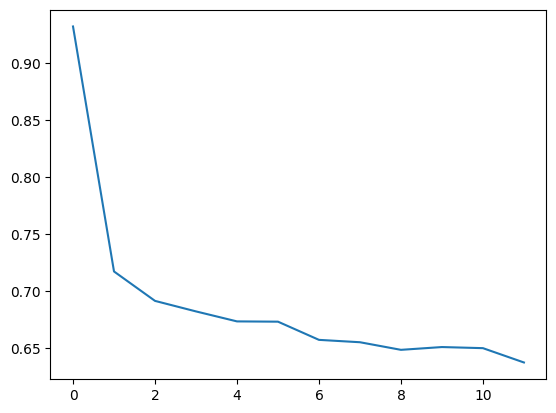

In [261]:
plt.plot([i for i in range(len(loss_i))], loss_i)

# Actually Using the Model

In [262]:
# for every movie, save all its embeddings
movieId_to_embedding = {}

for movieId in top_movies:
  movieId_to_embedding[movieId] = {}

  movieId_to_embedding[movieId]['MOVIEID_EMBEDDING'] = ITEM_EMBEDDING_LOOKUP[torch.tensor([item_emb_movieId_to_i[movieId]])]
  movieId_to_embedding[movieId]['MOVIE_FEATURE_EMBEDDING'] = torch.tanh(torch.tensor([movieId_to_context[movieId]]) @ i_W + i_b)

  # compute the combined (concat) item/movie embedding
  item_id_emb = movieId_to_embedding[movieId]['MOVIEID_EMBEDDING']
  item_feature_emb = movieId_to_embedding[movieId]['MOVIE_FEATURE_EMBEDDING']
  movieId_to_embedding[movieId]['MOVIE_EMBEDDING_COMBINED'] = torch.cat((item_feature_emb.view(item_feature_emb.size(0), -1),
                                       item_id_emb.view(item_id_emb.size(0), -1)), dim=1)

In [263]:
for emb_type in movieId_to_embedding[5952].keys():
  print(movieId_to_embedding[5952][emb_type].shape)

torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 40])


In [264]:
# for every movie, and for every embedding type, find the similary to all other embeddings
# NOTE: can be slow
movieId_to_emb_type_to_similarities = {}

for movieId in top_movies:
  movieId_to_emb_type_to_similarities[movieId] = {}

  for emb_type in movieId_to_embedding[movieId].keys():
    emb_to_target_to_dist = {}
    for target_id in top_movies:
      src = movieId_to_embedding[movieId][emb_type].view(-1)
      target = movieId_to_embedding[target_id][emb_type].view(-1)

      distance = torch.sqrt(torch.sum(torch.pow(torch.subtract(src, target), 2), dim=0))
      emb_to_target_to_dist[target_id] = distance
    movieId_to_emb_type_to_similarities[movieId][emb_type] = sorted(emb_to_target_to_dist.items(), key=lambda item: item[1])

### Finding Most Similar Movies

In [265]:
title_substring = 'Lord of'
# title_substring = 'Rata'
# title_substring = 'Star War'
# title_substring = 'Harry'

emb_type = 'MOVIEID_EMBEDDING'
emb_type = 'MOVIE_FEATURE_EMBEDDING'
emb_type = 'MOVIE_EMBEDDING_COMBINED'

# Print the top ten most similar movies (for all movies with the substring in title)
for movieId in top_movies:
  if title_substring not in movieId_to_title[movieId]: continue

  for target_id, dist in movieId_to_emb_type_to_similarities[movieId][emb_type][0:10]:
    print(movieId_to_title[target_id], dist)
  print()

Lord of the Rings: The Fellowship of the Ring, The (2001) tensor(0., grad_fn=<SqrtBackward0>)
Lord of the Rings: The Return of the King, The (2003) tensor(0.5718, grad_fn=<SqrtBackward0>)
Lord of the Rings: The Two Towers, The (2002) tensor(0.6355, grad_fn=<SqrtBackward0>)
Pirates of the Caribbean: The Curse of the Black Pearl (2003) tensor(0.9768, grad_fn=<SqrtBackward0>)
Hobbit: An Unexpected Journey, The (2012) tensor(0.9773, grad_fn=<SqrtBackward0>)
Gladiator (2000) tensor(0.9777, grad_fn=<SqrtBackward0>)
Indiana Jones and the Last Crusade (1989) tensor(0.9902, grad_fn=<SqrtBackward0>)
Harry Potter and the Prisoner of Azkaban (2004) tensor(0.9984, grad_fn=<SqrtBackward0>)
The Martian (2015) tensor(1.0127, grad_fn=<SqrtBackward0>)
Illusionist, The (2006) tensor(1.0217, grad_fn=<SqrtBackward0>)

Lord of the Rings: The Return of the King, The (2003) tensor(0., grad_fn=<SqrtBackward0>)
Lord of the Rings: The Fellowship of the Ring, The (2001) tensor(0.5718, grad_fn=<SqrtBackward0>)
Lor

### Get Recommendations for NEW USER

In [270]:
inference_user_context = [0.0] * user_context_size

# set genres the user likes or dislikes.
for genre in ['Fantasy']:
  inference_user_context[user_context_genre_to_i[genre]] = float(1.0)

# set movies the user likes or dislikes.
# liked_movie_title_substrings = ['Lord of']
# liked_movie_title_substrings = ['Finding', 'Up']
liked_movie_title_substrings = ['Lord of']
for movieId in user_context_movies:
  title = movieId_to_title[movieId]
  for title_substring in liked_movie_title_substrings:
    if title_substring in title:
      print("Adding movie: ", title)
      inference_user_context[user_context_movieId_to_i[movieId]] = float(1.0)


Adding movie:  Lord of the Rings: The Two Towers, The (2002)
Adding movie:  Lord of the Rings: The Fellowship of the Ring, The (2001)
Adding movie:  Lord of the Rings: The Return of the King, The (2003)


In [271]:
X_inference = torch.tensor([inference_user_context])
user_embedding_inference = torch.tanh(X_inference @ u_W1 + u_b1)

movieId_to_pred_score = {}
for movieId in top_movies:
  # we already have the combined item embedding for every movie to make inference easier.
  item_embedding_combined_inference = movieId_to_embedding[movieId]['MOVIE_EMBEDDING_COMBINED']
  movieId_to_pred_score[movieId] = torch.einsum('ij, ij -> i', user_embedding_inference, item_embedding_combined_inference).item()

for movieId, pred_score in list(sorted(movieId_to_pred_score.items(), key=lambda item: item[1], reverse=True))[:10]:
  print(movieId_to_title[movieId], pred_score)

Lord of the Rings: The Return of the King, The (2003) 1.5658529996871948
Lord of the Rings: The Fellowship of the Ring, The (2001) 1.5416498184204102
Lord of the Rings: The Two Towers, The (2002) 1.5191893577575684
Spirited Away (Sen to Chihiro no kamikakushi) (2001) 0.5502991676330566
Princess Mononoke (Mononoke-hime) (1997) 0.410987913608551
Matrix, The (1999) 0.38917630910873413
Harry Potter and the Goblet of Fire (2005) 0.38645994663238525
Harry Potter and the Prisoner of Azkaban (2004) 0.38464879989624023
Howl's Moving Castle (Hauru no ugoku shiro) (2004) 0.3739607036113739
Pirates of the Caribbean: The Curse of the Black Pearl (2003) 0.3645719289779663


In [198]:
# sanity check - make sure we aren't just recommending the higest rated movies
# NOTE: this is an extremely common problem in rec systems as the model learns
# to play it safe and just recommend what almost is highly rated.
for movieId, avg_rating in movieId_to_avg_rating_sorted[0:10]:
  print(movieId_to_title[movieId], avg_rating)

Shawshank Redemption, The (1994) 4.416892377425239
Godfather, The (1972) 4.319259791591808
Godfather: Part II, The (1974) 4.262827822120866
Usual Suspects, The (1995) 4.25674801257164
12 Angry Men (1957) 4.254069767441861
Seven Samurai (Shichinin no samurai) (1954) 4.244835501147667
Fight Club (1999) 4.239006482855581
Schindler's List (1993) 4.226748839442933
One Flew Over the Cuckoo's Nest (1975) 4.204533189422558
Rear Window (1954) 4.19997421351212
